# Example 2: Lau et al.

The second example comes from Lau et al. (2009), which analyzed data on 1164 women with HIV from the Women's Interagency HIV Study (WIHS). The parameter of interest was the average causal effect on the composite outcome comparing history of injection drug use to no history at 3653 days (10 years). Confounding variables included race, age, and nadir CD4. Nadir CD4 and age are modeled using restricted quadratic splines with knots at $2.1,3.5,5.2$ and $25, 35, 50$, respectively.

## Setup

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from time import time
import delicatessen as deli
from delicatessen import MEstimator
from delicatessen.utilities import spline

from efuncs import ee_pooled_logit, pooled_logit_prediction

print("NumPy version:       ", np.__version__)
print("SciPy version:       ", sp.__version__)
print("Pandas version:      ", pd.__version__)
print("Matplotlib version:  ", matplotlib.__version__)
print("Delicatessen version:", deli.__version__)

NumPy version:        1.25.2
SciPy version:        1.11.2
Pandas version:       1.4.1
Matplotlib version:   3.9.2
Delicatessen version: 3.1


In [2]:
d = pd.read_csv("data/lau.csv")

# Generating splines for continuous variables
d[['cd4_sp1', 'cd4_sp2']] = spline(d['cd4nadir'], knots=[2.1, 3.5, 5.2], power=2, restricted=True, normalized=False)
d[['age_sp1', 'age_sp2']] = spline(d['ageatfda'], knots=[25, 35, 50], power=2, restricted=True, normalized=False)

# Maxing maximum follow-up 10 years
d['event'] = np.where(d['eventtype'] == 2, 1, 0)
d['event'] = np.where(d['t'] > 10, 0, d['event'])
d['t'] = np.where(d['t'] > 10, 10, d['t'])

# Transforming time into days
d['days'] = np.ceil(d['t'] * 365.25)
d['months'] = np.ceil(d['days'] / 30.437)

In [3]:
time_var = 'days'
delta_var = 'event'
act_var = 'BASEIDU'
a = np.asarray(d[act_var])
t = np.asarray(d[time_var])
y = np.asarray(d[delta_var])
W = np.asarray(d[['black', 'cd4nadir', 'cd4_sp1', 'cd4_sp2', 'ageatfda', 'age_sp1', 'age_sp2']])

## Fitting Treatment-Stratified Pooled Logistic Model

To begin, we illustrate how stratified pooled logistic regression models are fit. Here, models are stratified by treatment, which avoids a proportional hazards assumption for treatment, and also incorporates interactions between treatment and other baseline variables. 

### Disjoint Indicators for Time

Starting with $A=1$, a pooled logistic model can be estimated via

In [4]:
event_times_a1 = list(np.unique(d.loc[(d[delta_var] == 1) & (d[act_var] == 1), time_var]))
params_plr_a1 = len(event_times_a1)

In [5]:
def psi_plogit_a1(theta):
    ee_plog = ee_pooled_logit(theta, t=t, delta=y, X=W, unique_times=event_times_a1)
    ee_plog = ee_plog * (a == 1)[None, :]
    return ee_plog

In [6]:
inits = ([0., ]*W.shape[1] + [-4., ] +   # Coefs for baseline vars
         [0., ]*(params_plr_a1 - 1))     # Coefs for time terms
estr = MEstimator(psi_plogit_a1, init=inits)
estr.estimate()

In [7]:
starting_a1 = list(estr.theta)
beta_x = estr.theta[:W.shape[1]]
beta_s = estr.theta[W.shape[1]:]
print(beta_x)
# print(beta_s)

[ 0.03218578 -0.42678191 -0.04785856  0.24066429  0.23576935 -0.01451363
  0.0179291 ]


The same process can be applied for $A=0$, illustrated below

In [8]:
# Unique events times for A=0
event_times_a0 = list(np.unique(d.loc[(d[delta_var] == 1) & (d[act_var] == 0), time_var]))
params_plr_a0 = len(event_times_a0)

# Defining estimating function
def psi_plogit_a0(theta):
    ee_plog = ee_pooled_logit(theta, t=t, delta=y, X=W, unique_times=event_times_a0)
    ee_plog = ee_plog * (a == 0)[None, :]
    return ee_plog

# Applying M-estimator procedure
inits = ([0., ]*W.shape[1] + [-4., ] +   # Coefs for baseline vars
         [0., ]*(params_plr_a0 - 1))     # Coefs for time terms
estr = MEstimator(psi_plogit_a0, init=inits)
estr.estimate()

# Showing results
starting_a0 = list(estr.theta)
beta_x = estr.theta[:W.shape[1]]
beta_s = estr.theta[W.shape[1]:]
print(beta_x)
# print(beta_s)

[ 7.57689917e-02 -9.08573177e-01  2.87512383e-01 -2.57698613e-01
  4.09112989e-02  7.97760754e-04 -4.78290399e-03]


### Splines for Time

Rather than modeling time with disjoint indicators, one can also use parametric function forms. Here, we use restricted quadratic splines

In [9]:
max_time = int(np.max(d[time_var]))
t_steps = np.asarray(range(1, max_time+1))
intercept = np.ones(t_steps.shape)[:, None]
time_splines = spline(t_steps, knots=[500, 1000, 2000, 3000, 3500],
                      power=2, restricted=True, normalized=False)
s_matrix = np.concatenate([intercept, t_steps[:, None], time_splines], axis=1)

In [10]:
def psi_plogit_spline_a1(theta):
    ee_plog = ee_pooled_logit(theta=theta, t=t, delta=y, X=W, S=s_matrix)
    ee_plog = ee_plog * (a == 1)[None, :]
    return ee_plog

In [11]:
inits = [0., ]*W.shape[1] + [-8., ] + [0., ]*5
estr = MEstimator(psi_plogit_spline_a1, init=inits)
estr.estimate()

In [12]:
starting_a1_sp = list(estr.theta)
beta_x = estr.theta[:W.shape[1]]
beta_s = estr.theta[W.shape[1]:]
print(beta_x)
print(beta_s)

[ 0.02834604 -0.42124355 -0.05118063  0.24494626  0.23373897 -0.01431099
  0.01766006]
[-1.28375320e+01 -6.48276569e-04  9.94612786e-07 -1.13737644e-06
 -7.97549994e-07  6.50320188e-06]


Again, the same process can be applied for $A=0$

In [13]:
def psi_plogit_spline_a0(theta):
    ee_plog = ee_pooled_logit(theta=theta, t=t, delta=y, X=W, S=s_matrix)
    ee_plog = ee_plog * (a == 0)[None, :]
    return ee_plog

# Applying M-estimator procedure
inits = [0., ]*W.shape[1] + [-8., ] + [0., ]*5
estr = MEstimator(psi_plogit_spline_a0, init=inits)
estr.estimate()

# Showing results
starting_a0_sp = list(estr.theta)
beta_x = estr.theta[:W.shape[1]]
beta_s = estr.theta[W.shape[1]:]
print(beta_x)
print(beta_s)

[ 6.12484089e-02 -9.02705746e-01  2.81202460e-01 -2.47628177e-01
  4.05356325e-02  7.90255539e-04 -4.72463033e-03]
[-7.83793634e+00  5.60634265e-04 -8.19224051e-07  1.03109877e-06
 -8.59963785e-07 -1.05856380e-05]


## Estimating the Risk Difference

The pooled logistic regression model is simply a nuisance model for the parameters were are interested in. Here, we apply the g-computation estimator to obtain the marginal risk differences. To simply writing the function, we call the previously defined pooled logistic model functions

### Disjoint Indicators for Time

First, consider how the disjoint indicators for time can be used to model the risk difference over follow-up

In [14]:
event_times = [0, ] + list(np.unique(d.loc[d[delta_var] == 1, time_var])) + [np.max(t), ]
event_times_a1 = list(np.unique(d.loc[(d[delta_var] == 1) & (d[act_var] == 1), time_var]))
event_times_p1 = [0, ] + event_times_a1 + [np.max(t), ]
event_times_a0 = list(np.unique(d.loc[(d[delta_var] == 1) & (d[act_var] == 0), time_var]))
event_times_p0 = [0, ] + event_times_a0 + [np.max(t), ]
params_rd = len(event_times)
params_r1 = len(event_times_p1)
params_r0 = len(event_times_p0)
params_plr_a1 = len(event_times_a1)
params_plr_a0 = len(event_times_a0)

In [15]:
def psi_rd(theta):
    # Extracting parameters
    rds = theta[:params_rd]
    idPLR = params_rd + W.shape[1] + params_plr_a1
    beta1 = theta[params_rd: idPLR]
    beta0 = theta[idPLR:]

    # Nuisance models
    ee_plog1 = psi_plogit_a1(theta=beta1)
    ee_plog0 = psi_plogit_a0(theta=beta0)

    # Predictions to get risk differences
    risk1 = pooled_logit_prediction(theta=beta1, delta=y, t=t, X=W,
                                    times_to_predict=event_times, measure='risk', unique_times=event_times_a1)
    risk0 = pooled_logit_prediction(theta=beta0, delta=y, t=t, X=W,
                                    times_to_predict=event_times, measure='risk', unique_times=event_times_a0)
    ee_rd = (risk1 - risk0) - np.asarray(rds)[:, None]

    # Returning stacked estimating equations
    return np.vstack([ee_rd, ee_plog1, ee_plog0])

In [16]:
inits = [0., ]*params_rd + starting_a1 + starting_a0
estr = MEstimator(psi_rd, init=inits)
estr.estimate()

In [17]:
rd = estr.theta[:params_rd]
rd_ci = estr.confidence_intervals()[:params_rd, :]
rd_results = pd.DataFrame()
rd_results['time'] = event_times
rd_results['rd'] = rd
rd_results['lcl'] = rd_ci[:, 0]
rd_results['ucl'] = rd_ci[:, 1]

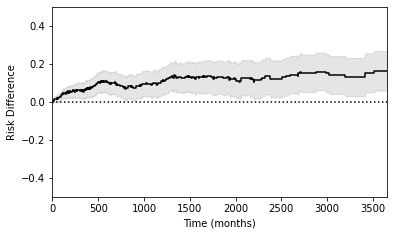

In [18]:
fig, ax = plt.subplots(figsize=[6, 3.5])
ax.axhline(y=0, linestyle=':', color='k')
ax.fill_between(rd_results['time'], rd_results['lcl'], rd_results['ucl'], color='k', alpha=0.1, step='post')
ax.step(rd_results['time'], rd_results['rd'], color='k', where='post')
ax.set_xlim([0, max_time+5])
ax.set_ylim([-0.5, 0.5])
ax.set_xlabel("Time (months)")
ax.set_ylabel("Risk Difference")
plt.show()

### Splines for Time

Repeating estimation of the risk difference but with splines for time.

In [19]:
tp_intervals = [0, ] + list(range(1, max_time+1, 50)) + [np.max(t), ]
params_risk = len(tp_intervals)

In [20]:
def psi_rd(theta):
    # Extracting parameters
    risks = theta[:params_risk]
    idPLRM = params_risk + W.shape[1] + s_matrix.shape[1]
    beta1 = theta[params_risk:idPLRM]
    beta0 = theta[idPLRM:]

    # Nuisance models
    ee_plog1 = psi_plogit_spline_a1(theta=beta1)
    ee_plog0 = psi_plogit_spline_a0(theta=beta0)

    # Predictions to get risk differences
    risk1 = pooled_logit_prediction(theta=beta1, t=t, delta=y, X=W, S=s_matrix,
                                    times_to_predict=tp_intervals, measure='risk')
    risk0 = pooled_logit_prediction(theta=beta0, t=t, delta=y, X=W, S=s_matrix,
                                    times_to_predict=tp_intervals, measure='risk')
    ee_rd = (risk1 - risk0) - np.asarray(risks)[:, None]

    # Returning stacked estimating equations
    return np.vstack([ee_rd, ee_plog1, ee_plog0])

In [21]:
inits = [0., ]*params_risk + starting_a1_sp + starting_a0_sp
estr = MEstimator(psi_rd, init=inits)
estr.estimate()

In [22]:
rd_results = pd.DataFrame()
rd_results['time'] = tp_intervals
rd_results['rd'] = estr.theta[:params_risk]
rd_ci = estr.confidence_intervals()[:params_risk, :]
rd_results['lcl'] = rd_ci[:, 0]
rd_results['ucl'] = rd_ci[:, 1]

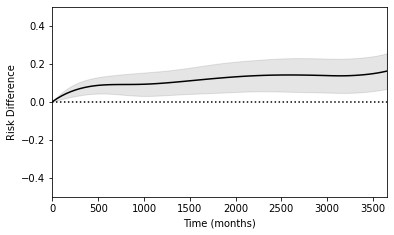

In [23]:
fig, ax = plt.subplots(figsize=[6, 3.5])
ax.axhline(y=0, linestyle=':', color='k')
ax.fill_between(rd_results['time'], rd_results['lcl'], rd_results['ucl'], color='k', alpha=0.1)
ax.plot(rd_results['time'], rd_results['rd'], color='k')
ax.set_xlim([0, max_time+5])
ax.set_ylim([-0.5, 0.5])
ax.set_xlabel("Time (months)")
ax.set_ylabel("Risk Difference")
plt.show()

This completes the walkthrough of the example. If you wish to view the code for how the figures for the publication were generated or the timing between different implementations, please see the corresponding files described in the README.